In [1]:
%run ../input/python-recipes/radial_gradient_header.py
%radial_gradient_header Code Modules & Helpful Tools|24

In [2]:
import os,h5py,tarfile,math,PIL
import numpy as np,pandas as pd
import tensorflow as tf,pylab as pl
from tensorflow.keras import layers as tkl
from tensorflow.keras import callbacks as tkc
from tensorflow.keras.preprocessing.image import \
load_img,array_to_img,img_to_array
from tensorflow.keras.preprocessing import \
image_dataset_from_directory
from mpl_toolkits.axes_grid1.inset_locator import \
zoomed_inset_axes,mark_inset
data_url='https://raw.githubusercontent.com/'+\
         'OlgaBelitskaya/data_kitchen/main/'
file_path='../input/object-detection/resolution/'
tar_file='resolution.tgz'

In [3]:
%radial_gradient_header Data Files|24

In [4]:
folder_names=['train','valid','test']
file_names=[[],[],[]]
for root,dirs,files in os.walk(file_path,topdown=True):
    for f in files:
        if '.jpg' in os.path.join(root,f):
            for i in range(3):
                if folder_names[i] in os.path.join(root,f): 
                    file_name=os.path.join(root,f)\
                    .replace(file_path,'')
                    file_names[i].append(file_name)
    for d in dirs:
        print(os.path.join(root,d),'\n',20*'<=>')
df=pd.DataFrame(file_names,index=folder_names).T
df.head()

../input/object-detection/resolution/data 
 <=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
../input/object-detection/resolution/data/images 
 <=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
../input/object-detection/resolution/data/images/valid 
 <=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
../input/object-detection/resolution/data/images/test 
 <=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
../input/object-detection/resolution/data/images/train 
 <=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>


train                       valid  \
0  data/images/train/0106.jpg  data/images/valid/0006.jpg   
1  data/images/train/0074.jpg  data/images/valid/0044.jpg   
2  data/images/train/0077.jpg  data/images/valid/0011.jpg   
3  data/images/train/0058.jpg  data/images/valid/0019.jpg   
4  data/images/train/0128.jpg  data/images/valid/0008.jpg   

                        test  
0  data/images/test/0006.jpg  
1  data/images/test/0044.jpg  
2  data/images/test/0011.jpg  
3  data/images/test/0019.jpg  
4  data/images/test/0008.jpg

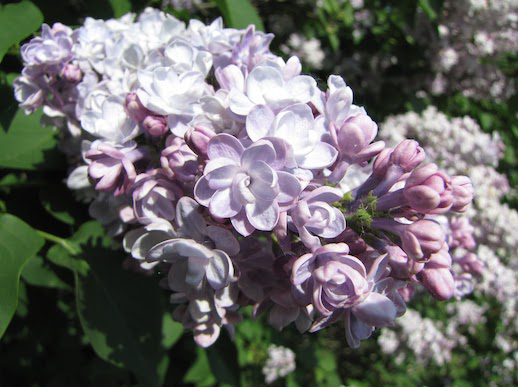

In [5]:
PIL.Image.open(file_path+df['valid'][7])

In [6]:
%radial_gradient_header Tar Archives|24 

In [7]:
with tarfile.open(tar_file,'w:gz') as tar:
    for root,dirs,files in os.walk(file_path):
        for f in files:
            file_name=os.path.join(root,f).replace(file_path,'')
            tar.add(os.path.join(root,f),file_name)
    tar.close()

In [8]:
file_names=[[],[],[]]
with tarfile.open(tar_file,'r:gz') as tar:
    files=tar.getnames()
    tar.close()
for i in range(3):
    for f in files:
        if folder_names[i] in f:
            file_names[i].append(f)
df=pd.DataFrame(file_names,index=folder_names).T
df.tail() 

train valid  test
175  data/images/train/0115.jpg  None  None
176  data/images/train/0086.jpg  None  None
177  data/images/train/0170.jpg  None  None
178  data/images/train/0001.jpg  None  None
179  data/images/train/0176.jpg  None  None

In [9]:
%radial_gradient_header TF Data from Tar Files|24

In [10]:
def scale01(img): return img/255
def process_input(input_rgb,img_size):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return tf.image.resize(y,[img_size,img_size],method='area')
def process_target(input_rgb):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return y

In [11]:
data_dir=tf.keras.utils.get_file(
    origin=data_url+tar_file,fname='resolution',
    extract=True,cache_dir='./')[:-11]
root_dir=os.path.join(data_dir,'data')
data_path=os.path.join(root_dir,'images')
test_path=os.path.join(data_path,'test')
test_paths=sorted(
    [os.path.join(test_path,fname) 
     for fname in os.listdir(test_path)
     if fname.endswith('.jpg')])
test_paths[:3]

24633344/24626244 [==============================] - 0s 0us/step


['./datasets/data/images/test/0001.jpg',
 './datasets/data/images/test/0002.jpg',
 './datasets/data/images/test/0003.jpg']

Found 270 files belonging to 1 classes.
Using 216 files for training.
Found 270 files belonging to 1 classes.
Using 54 files for validation.


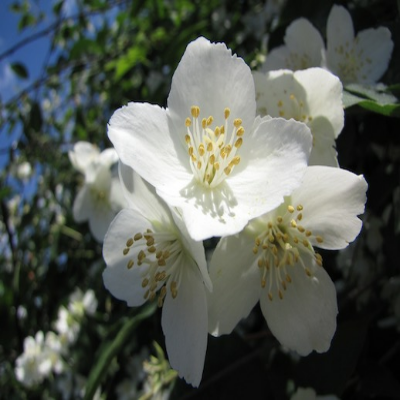

In [12]:
[crop_size,upscale_factor]=[400,4]
input_size=crop_size//upscale_factor
batch_size=8
train_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='training',
    seed=12,label_mode=None,)
valid_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='validation',
    seed=123,label_mode=None,)
train_ds=train_ds.map(scale01)
valid_ds=valid_ds.map(scale01)
for batch in train_ds.take(1):
    for img in batch: display(array_to_img(img)); break

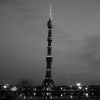

==> ==> ==> ==> ==> ==> ==> ==> ==> ==> 


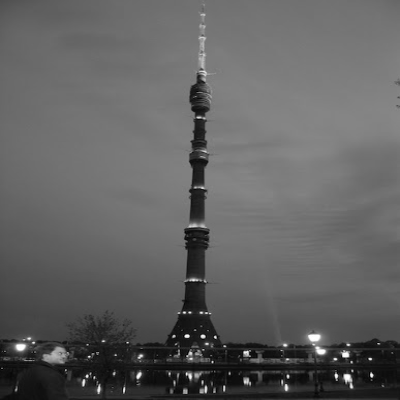

In [13]:
train_ds=train_ds.map(
    lambda x: (process_input(x,input_size),process_target(x)))
train_ds=train_ds.prefetch(buffer_size=16)
valid_ds=valid_ds.map(
    lambda x: (process_input(x,input_size),process_target(x)))
valid_ds=valid_ds.prefetch(buffer_size=16)
for batch in valid_ds.take(1):
    for img in batch[0]: display(array_to_img(img)); break
    print(10*'==> ')
    for img in batch[1]: display(array_to_img(img)); break

In [14]:
%radial_gradient_header Usage in Super-Resolution|24

In [15]:
def model(upscale_factor=upscale_factor,channels=1):
    conv_args={'activation':'relu',
               'kernel_initializer':'Orthogonal',
               'padding':'same',}
    inputs=tf.keras.Input(shape=(None,None,channels))
    x=tkl.Conv2D(512,5,**conv_args)(inputs)
    x=tkl.Conv2D(96,5,**conv_args)(x)
    x=tkl.Conv2D(32,3,**conv_args)(x)
    x=tkl.Conv2D(channels*(upscale_factor**2),3,**conv_args)(x)
    outputs=tf.nn.depth_to_space(x,upscale_factor)
    return tf.keras.Model(inputs,outputs)

In [16]:
def display_results(img,prefix,title):
    img_array=img_to_array(img)
    img_array=img_array.astype('float32')/255
    fig,ax=pl.subplots()
    im=ax.imshow(img_array[::-1],origin='lower')
    pl.title(title)
    axins=zoomed_inset_axes(ax,2,loc=5)
    axins.imshow(img_array[::-1],origin='lower')
    x1,x2,y1,y2=200,300,100,200
    axins.set_xlim(x1,x2); axins.set_ylim(y1,y2)
    pl.yticks(visible=False); pl.xticks(visible=False)
    mark_inset(ax,axins,loc1=2,loc2=3,fc='none',ec='magenta')
    pl.savefig(str(prefix)+'-'+title+'.png')
    pl.show()
def low_resolution_img(img,upscale_factor):
    dimensions=(img.size[0]//upscale_factor,
                img.size[1]//upscale_factor)
    return img.resize(dimensions,PIL.Image.BICUBIC,)
def upscale_img(model,img):
    ycbcr=img.convert('YCbCr')
    y,cb,cr=ycbcr.split()
    y=img_to_array(y).astype('float32')/255
    input_img=np.expand_dims(y,axis=0)
    out=model.predict(input_img)
    out_img_y=out[0]*255.
    out_img_y=out_img_y.clip(0,255)
    out_img_y=out_img_y.reshape(
        (np.shape(out_img_y)[0],np.shape(out_img_y)[1]))
    out_img_y=PIL.Image.fromarray(np.uint8(out_img_y),mode='L')
    out_img_cb=cb.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img_cr=cr.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img=PIL.Image.merge(
        'YCbCr',(out_img_y,out_img_cb,out_img_cr))
    return out_img.convert('RGB')

In [17]:
class ESPCNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback,self).__init__()
        self.test_img=low_resolution_img(
            load_img(test_paths[0]),upscale_factor)
    def on_epoch_begin(self,epoch,logs=None):
        self.psnr=[]
    def on_epoch_end(self,epoch,logs=None):
        print('mean PSNR for epoch: %.2f'%(np.mean(self.psnr)))
        if epoch%25==0:
            prediction=upscale_img(self.model,self.test_img)
            display_results(
                prediction,'epoch-'+str(epoch),'prediction')
    def on_test_batch_end(self,batch,logs=None):
        self.psnr.append(10*math.log10(1/logs['loss']))

In [18]:
early_stopping=tkc.EarlyStopping(monitor='loss',verbose=2,patience=10)
checkpoint_path='/tmp/checkpoint'
checkpoint=tkc.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    monitor='loss',mode='min',save_best_only=True,verbose=2)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',patience=10,verbose=2,factor=.9)

In [19]:
model=model(upscale_factor=upscale_factor,channels=1)
callbacks=[ESPCNCallback(),early_stopping,checkpoint,lr_reduction]
loss_fn=tf.keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.Adam(learning_rate=.0005)

Epoch 1/300
27/27 - 6s - loss: 0.0657 - val_loss: 0.0191
mean PSNR for epoch: 17.13


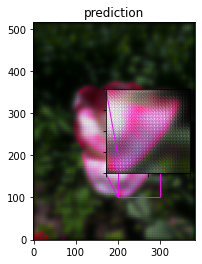


Epoch 00001: loss improved from inf to 0.06570, saving model to /tmp/checkpoint
Epoch 2/300
27/27 - 3s - loss: 0.0129 - val_loss: 0.0090
mean PSNR for epoch: 20.45

Epoch 00002: loss improved from 0.06570 to 0.01287, saving model to /tmp/checkpoint
Epoch 3/300
27/27 - 2s - loss: 0.0080 - val_loss: 0.0065
mean PSNR for epoch: 22.15

Epoch 00003: loss improved from 0.01287 to 0.00802, saving model to /tmp/checkpoint
Epoch 4/300
27/27 - 3s - loss: 0.0061 - val_loss: 0.0052
mean PSNR for epoch: 22.61

Epoch 00004: loss improved from 0.00802 to 0.00615, saving model to /tmp/checkpoint
Epoch 5/300
27/27 - 2s - loss: 0.0049 - val_loss: 0.0045
mean PSNR for epoch: 23.38

Epoch 00005: loss improved from 0.00615 to 0.00494, saving model to /tmp/checkpoint
Epoch 6/300
27/27 - 2s - loss: 0.0043 - val_loss: 0.0040
mean PSNR for epoch: 24.00

Epoch 00006: loss improved from 0.00494 to 0.00429, saving model to /tmp/checkpoint
Epoch 7/300
27/27 - 3s - loss: 0.0042 - val_loss: 0.0049
mean PSNR for epo

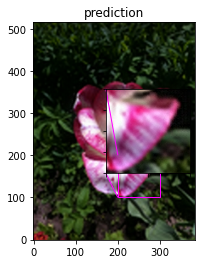


Epoch 00026: loss improved from 0.00302 to 0.00301, saving model to /tmp/checkpoint
Epoch 27/300
27/27 - 2s - loss: 0.0030 - val_loss: 0.0029
mean PSNR for epoch: 25.26

Epoch 00027: loss improved from 0.00301 to 0.00299, saving model to /tmp/checkpoint
Epoch 28/300
27/27 - 2s - loss: 0.0030 - val_loss: 0.0029
mean PSNR for epoch: 25.33

Epoch 00028: loss improved from 0.00299 to 0.00299, saving model to /tmp/checkpoint
Epoch 29/300
27/27 - 2s - loss: 0.0030 - val_loss: 0.0029
mean PSNR for epoch: 25.48

Epoch 00029: loss improved from 0.00299 to 0.00298, saving model to /tmp/checkpoint
Epoch 30/300
27/27 - 3s - loss: 0.0030 - val_loss: 0.0031
mean PSNR for epoch: 25.55

Epoch 00030: loss did not improve from 0.00298
Epoch 31/300
27/27 - 2s - loss: 0.0032 - val_loss: 0.0031
mean PSNR for epoch: 25.33

Epoch 00031: loss did not improve from 0.00298
Epoch 32/300
27/27 - 2s - loss: 0.0031 - val_loss: 0.0029
mean PSNR for epoch: 25.12

Epoch 00032: loss did not improve from 0.00298
Epoch 

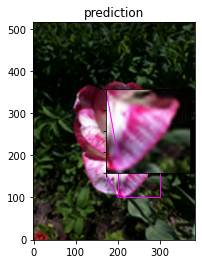


Epoch 00051: loss improved from 0.00292 to 0.00291, saving model to /tmp/checkpoint
Epoch 52/300
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 25.51

Epoch 00052: loss improved from 0.00291 to 0.00291, saving model to /tmp/checkpoint
Epoch 53/300
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 25.57

Epoch 00053: loss improved from 0.00291 to 0.00291, saving model to /tmp/checkpoint
Epoch 54/300
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 25.96

Epoch 00054: loss improved from 0.00291 to 0.00290, saving model to /tmp/checkpoint
Epoch 55/300
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 24.96

Epoch 00055: loss improved from 0.00290 to 0.00290, saving model to /tmp/checkpoint
Epoch 56/300
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 25.41

Epoch 00056: loss improved from 0.00290 to 0.00290, saving model to /tmp/checkpoint
Epoch 57/300
27/27 - 3s - loss: 0.0029 - val_loss: 0.0028
mean PS

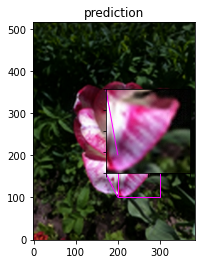


Epoch 00076: loss improved from 0.00287 to 0.00286, saving model to /tmp/checkpoint
Epoch 77/300
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 25.66

Epoch 00077: loss improved from 0.00286 to 0.00286, saving model to /tmp/checkpoint
Epoch 78/300
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 25.61

Epoch 00078: loss improved from 0.00286 to 0.00286, saving model to /tmp/checkpoint
Epoch 79/300
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 25.82

Epoch 00079: loss improved from 0.00286 to 0.00286, saving model to /tmp/checkpoint

Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.00029524502169806513.
Epoch 80/300
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 25.73

Epoch 00080: loss improved from 0.00286 to 0.00286, saving model to /tmp/checkpoint
Epoch 81/300
27/27 - 2s - loss: 0.0029 - val_loss: 0.0028
mean PSNR for epoch: 25.82

Epoch 00081: loss improved from 0.00286 to 0.00285, saving model to

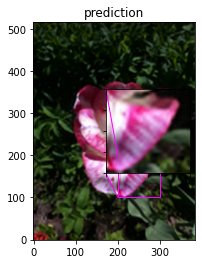


Epoch 00101: loss did not improve from 0.00283
Epoch 102/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0028
mean PSNR for epoch: 25.49

Epoch 00102: loss did not improve from 0.00283
Epoch 103/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0028
mean PSNR for epoch: 25.35

Epoch 00103: loss improved from 0.00283 to 0.00282, saving model to /tmp/checkpoint
Epoch 104/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0028
mean PSNR for epoch: 25.36

Epoch 00104: loss improved from 0.00282 to 0.00282, saving model to /tmp/checkpoint
Epoch 105/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0028
mean PSNR for epoch: 26.02

Epoch 00105: loss improved from 0.00282 to 0.00282, saving model to /tmp/checkpoint
Epoch 106/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0028
mean PSNR for epoch: 25.41

Epoch 00106: loss improved from 0.00282 to 0.00282, saving model to /tmp/checkpoint
Epoch 107/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0028
mean PSNR for epoch: 25.47

Epoch 00107: loss did not improve from 0.00282


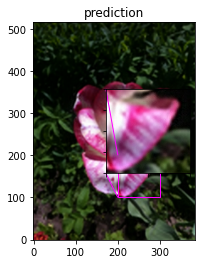


Epoch 00126: loss improved from 0.00280 to 0.00280, saving model to /tmp/checkpoint
Epoch 127/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.79

Epoch 00127: loss did not improve from 0.00280
Epoch 128/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.50

Epoch 00128: loss did not improve from 0.00280
Epoch 129/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.62

Epoch 00129: loss did not improve from 0.00280

Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.00017433923785574736.
Epoch 130/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.25

Epoch 00130: loss improved from 0.00280 to 0.00280, saving model to /tmp/checkpoint
Epoch 131/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 26.44

Epoch 00131: loss improved from 0.00280 to 0.00279, saving model to /tmp/checkpoint
Epoch 132/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.24

Ep

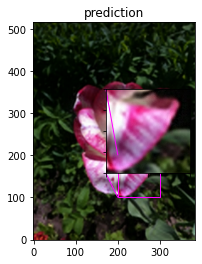


Epoch 00151: loss did not improve from 0.00278
Epoch 152/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.82

Epoch 00152: loss improved from 0.00278 to 0.00278, saving model to /tmp/checkpoint
Epoch 153/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.89

Epoch 00153: loss did not improve from 0.00278
Epoch 154/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.89

Epoch 00154: loss did not improve from 0.00278
Epoch 155/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.62

Epoch 00155: loss did not improve from 0.00278
Epoch 156/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.23

Epoch 00156: loss did not improve from 0.00278
Epoch 157/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.51

Epoch 00157: loss improved from 0.00278 to 0.00278, saving model to /tmp/checkpoint
Epoch 158/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for e

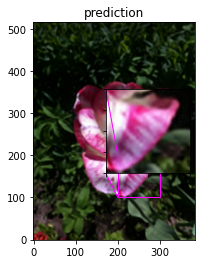


Epoch 00176: loss improved from 0.00277 to 0.00277, saving model to /tmp/checkpoint
Epoch 177/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 26.20

Epoch 00177: loss improved from 0.00277 to 0.00277, saving model to /tmp/checkpoint
Epoch 178/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.23

Epoch 00178: loss did not improve from 0.00277
Epoch 179/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.91

Epoch 00179: loss did not improve from 0.00277
Epoch 180/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.33

Epoch 00180: loss did not improve from 0.00277

Epoch 00180: ReduceLROnPlateau reducing learning rate to 0.00010294557214365342.
Epoch 181/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.54

Epoch 00181: loss improved from 0.00277 to 0.00276, saving model to /tmp/checkpoint
Epoch 182/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.40

Ep

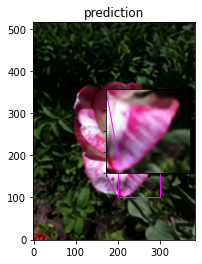


Epoch 00201: loss did not improve from 0.00276
Epoch 202/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 26.03

Epoch 00202: loss improved from 0.00276 to 0.00276, saving model to /tmp/checkpoint
Epoch 203/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.54

Epoch 00203: loss improved from 0.00276 to 0.00276, saving model to /tmp/checkpoint
Epoch 204/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 26.57

Epoch 00204: loss improved from 0.00276 to 0.00275, saving model to /tmp/checkpoint
Epoch 205/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.96

Epoch 00205: loss did not improve from 0.00275
Epoch 206/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.46

Epoch 00206: loss improved from 0.00275 to 0.00275, saving model to /tmp/checkpoint
Epoch 207/300
27/27 - 2s - loss: 0.0028 - val_loss: 0.0027
mean PSNR for epoch: 25.58

Epoch 00207: loss did not improve from 0.00275


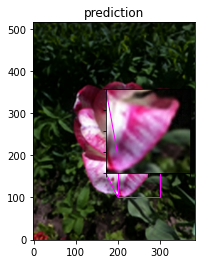


Epoch 00226: loss did not improve from 0.00275
Epoch 227/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.65

Epoch 00227: loss improved from 0.00275 to 0.00275, saving model to /tmp/checkpoint
Epoch 228/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.19

Epoch 00228: loss did not improve from 0.00275
Epoch 229/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.46

Epoch 00229: loss improved from 0.00275 to 0.00275, saving model to /tmp/checkpoint
Epoch 230/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 26.34

Epoch 00230: loss did not improve from 0.00275

Epoch 00230: ReduceLROnPlateau reducing learning rate to 6.078833175706677e-05.
Epoch 231/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 26.56

Epoch 00231: loss did not improve from 0.00275
Epoch 232/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.77

Epoch 00232: loss improved from 0.00275 

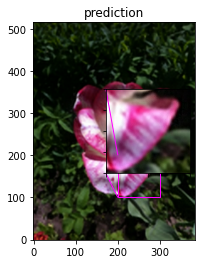


Epoch 00251: loss did not improve from 0.00274
Epoch 252/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.60

Epoch 00252: loss improved from 0.00274 to 0.00274, saving model to /tmp/checkpoint
Epoch 253/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.62

Epoch 00253: loss improved from 0.00274 to 0.00274, saving model to /tmp/checkpoint
Epoch 254/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 26.31

Epoch 00254: loss did not improve from 0.00274
Epoch 255/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.93

Epoch 00255: loss did not improve from 0.00274
Epoch 256/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.49

Epoch 00256: loss improved from 0.00274 to 0.00274, saving model to /tmp/checkpoint
Epoch 257/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.54

Epoch 00257: loss improved from 0.00274 to 0.00274, saving model to /tmp/checkpoint


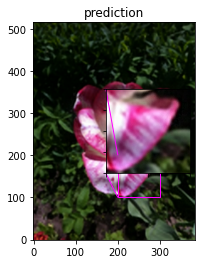


Epoch 00276: loss did not improve from 0.00273
Epoch 277/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 24.94

Epoch 00277: loss did not improve from 0.00273
Epoch 278/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 26.08

Epoch 00278: loss improved from 0.00273 to 0.00273, saving model to /tmp/checkpoint
Epoch 279/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.56

Epoch 00279: loss did not improve from 0.00273
Epoch 280/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 26.39

Epoch 00280: loss improved from 0.00273 to 0.00273, saving model to /tmp/checkpoint

Epoch 00280: ReduceLROnPlateau reducing learning rate to 3.5894901157007555e-05.
Epoch 281/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.95

Epoch 00281: loss improved from 0.00273 to 0.00273, saving model to /tmp/checkpoint
Epoch 282/300
27/27 - 2s - loss: 0.0027 - val_loss: 0.0027
mean PSNR for epoch: 25.78

Ep

In [20]:
epochs=300
model.compile(optimizer=optimizer,loss=loss_fn,)
history=model.fit(
    train_ds,epochs=epochs,callbacks=callbacks,
    validation_data=valid_ds,verbose=2)
model.load_weights(checkpoint_path);

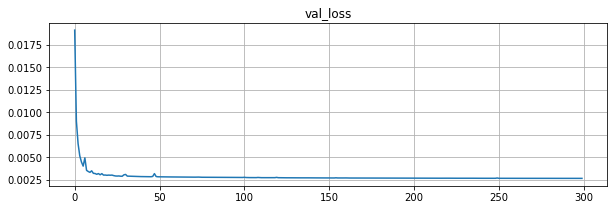

In [21]:
history_keys=list(history.history.keys())
pl.figure(figsize=(10,3))
pl.plot(history.history[history_keys[1]])
pl.grid(); pl.title(history_keys[1]);

PSNR of low resolution and high resolution is 27.7133
PSNR of predict and high resolution is 28.3449


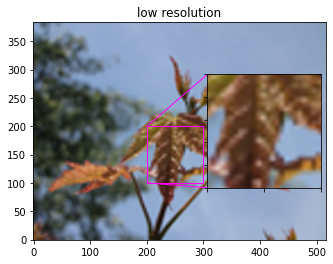

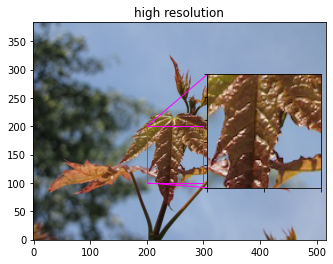

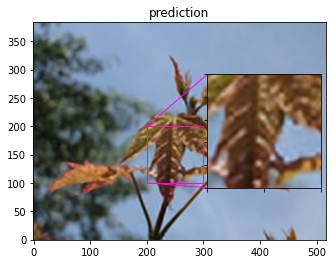

PSNR of low resolution and high resolution is 30.4634
PSNR of predict and high resolution is 31.8187


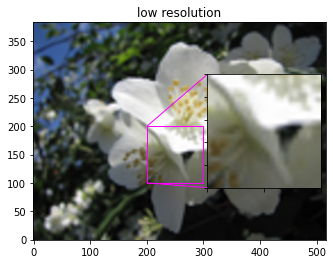

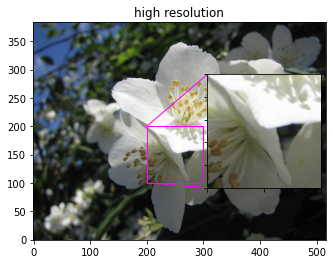

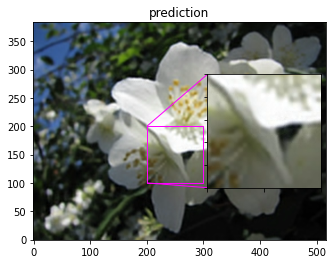

PSNR of low resolution and high resolution is 26.3540
PSNR of predict and high resolution is 27.4237


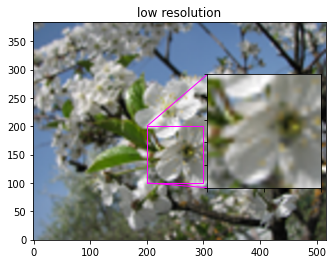

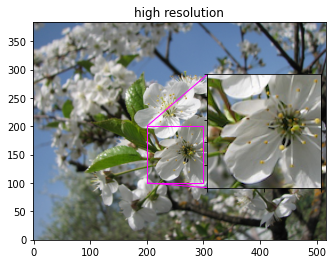

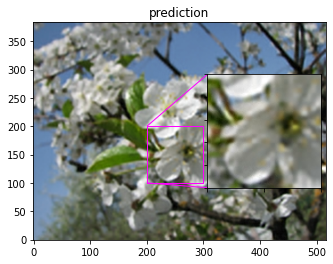

PSNR of low resolution and high resolution is 28.6121
PSNR of predict and high resolution is 29.7568


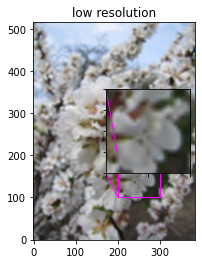

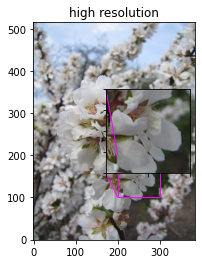

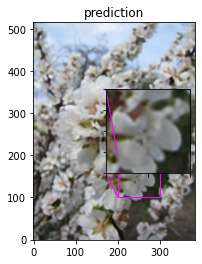

PSNR of low resolution and high resolution is 20.4599
PSNR of predict and high resolution is 20.8725


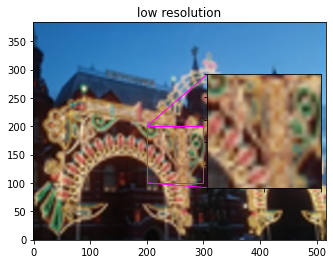

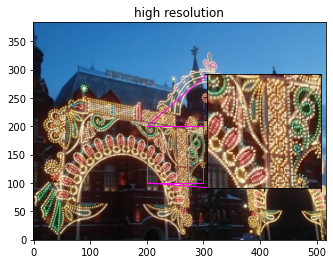

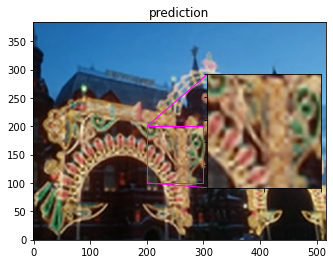

PSNR of low resolution and high resolution is 23.8670
PSNR of predict and high resolution is 24.4897


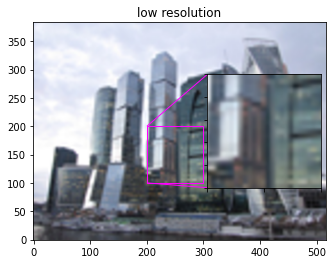

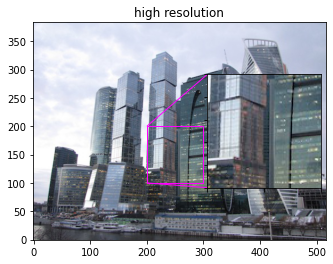

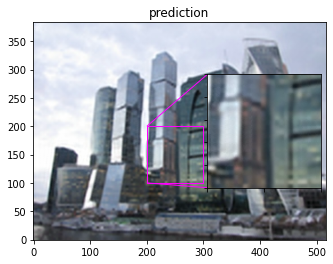

PSNR of low resolution and high resolution is 24.0932
PSNR of predict and high resolution is 25.3994


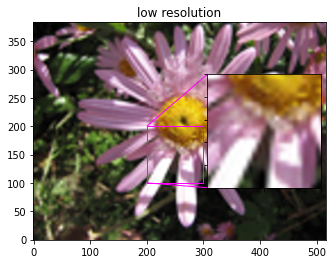

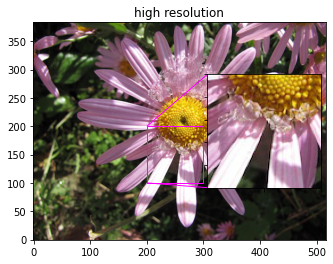

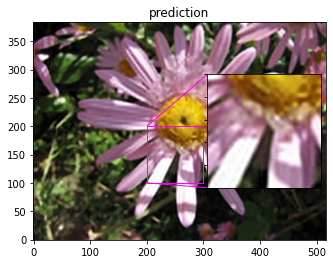

PSNR of low resolution and high resolution is 26.9738
PSNR of predict and high resolution is 27.9691


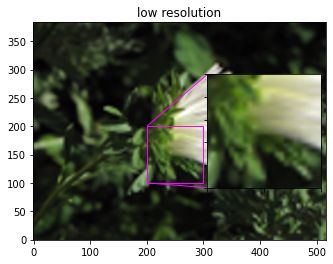

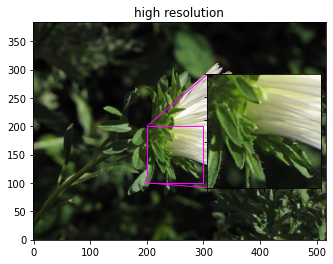

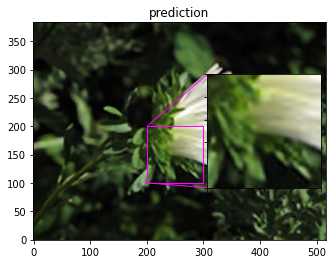

PSNR of low resolution and high resolution is 27.9112
PSNR of predict and high resolution is 28.5658


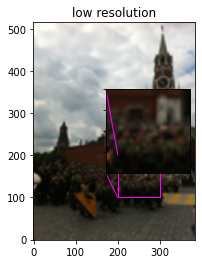

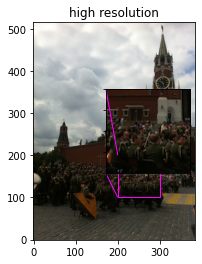

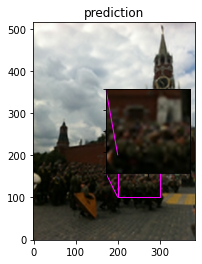

PSNR of low resolution and high resolution is 22.3869
PSNR of predict and high resolution is 23.1487


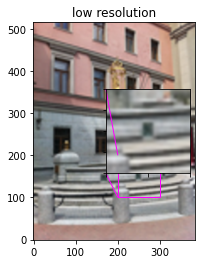

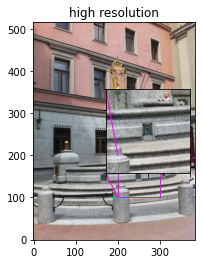

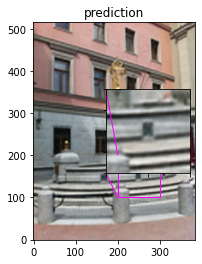

avg. PSNR of images with low resolution is 25.8835
avg. PSNR of reconstructions is 26.7789


In [22]:
total_bicubic_psnr=0.; total_test_psnr=0.; n_img=10
for index,test_path in enumerate(test_paths[5:5+n_img]):
    img=load_img(test_path)
    lowres_input=low_resolution_img(img,upscale_factor)
    w=lowres_input.size[0]*upscale_factor
    h=lowres_input.size[1]*upscale_factor
    highres_img=img.resize((w,h))
    predict_img=upscale_img(model,lowres_input)
    lowres_img=lowres_input.resize((w,h))
    lowres_img_arr=img_to_array(lowres_img)
    highres_img_arr=img_to_array(highres_img)
    predict_img_arr=img_to_array(predict_img)
    bicubic_psnr=tf.image.psnr(
        lowres_img_arr,highres_img_arr,max_val=255)
    test_psnr=tf.image.psnr(
        predict_img_arr,highres_img_arr,max_val=255)
    total_bicubic_psnr+=bicubic_psnr
    total_test_psnr+=test_psnr
    print('PSNR of low resolution '+\
          'and high resolution is %.4f'%bicubic_psnr)
    print('PSNR of predict and high resolution is %.4f'%test_psnr)
    display_results(lowres_img,index,'low resolution')
    display_results(highres_img,index,'high resolution')
    display_results(predict_img,index,'prediction')
print('avg. PSNR of images with low resolution is %.4f'\
      %(total_bicubic_psnr/n_img))
print('avg. PSNR of reconstructions is %.4f'\
      %(total_test_psnr/n_img))